<a href="https://colab.research.google.com/github/2359181042/DP/blob/main/Pandas_excise_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
#!pip install pytorch_lightning
!pip install -q pytorch-lightning

# Read csv files and create features

In [12]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()
import torch as torch

import argparse
import numpy as np
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn

import numpy as np
import scipy.sparse as sp
import torch
from torch.nn.functional import normalize

In [13]:
gcn_input=pd.read_csv(r'https://raw.githubusercontent.com/lehaifeng/T-GCN/master/T-GCN/T-GCN-PyTorch/data/los_speed.csv')

In [14]:
gcn_input

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,765604,767471,716339,773906,765273,716331,771667,716337,769953,769402,769403,769819,769405,716941,717578,716960,717804,767572,767573,773012,773013,764424,769388,716328,717819,769941,760987,718204,718045,769418,...,717582,717583,717580,716949,717587,772178,717585,716939,768469,764101,767554,773975,773974,717510,717513,717825,767495,767494,717821,717823,717458,717459,769926,764858,717450,717452,717453,759772,717456,771673,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
0,64.375000,67.625000,67.125000,61.500000,66.875000,68.750000,65.125000,67.125000,59.625000,62.750000,55.500000,66.500000,64.250000,68.500000,60.375000,67.500000,37.750000,63.125000,59.750000,62.125000,67.250000,41.250000,54.625000,58.125000,65.125000,64.250000,61.250000,62.750000,66.875000,47.375000,57.000000,67.750000,65.125000,66.875000,64.000000,62.000000,64.375000,60.750000,60.750000,62.375000,...,68.250000,62.000000,64.500000,58.375000,64.500000,63.625000,63.750000,53.625000,69.875000,64.750000,62.375000,64.750000,52.125000,61.625000,63.000000,67.142857,67.625000,63.875000,63.125000,63.375000,64.125000,66.875000,69.875000,67.750000,62.000000,66.750000,57.625000,52.625000,69.000000,43.500000,45.625000,65.500000,64.500000,66.428571,66.875000,59.375000,69.000000,59.250000,69.000000,61.875000
1,62.666667,68.555556,65.444444,62.444444,64.444444,68.111111,65.000000,65.000000,57.444444,63.333333,58.777778,58.444444,66.444444,65.444444,56.111111,65.444444,39.000000,63.777778,63.111111,66.111111,65.777778,56.777778,50.777778,56.222222,66.888889,54.444444,67.888889,61.555556,67.555556,46.777778,67.777778,67.888889,68.000000,67.444444,66.444444,67.222222,63.000000,64.333333,64.000000,61.888889,...,66.777778,66.555556,67.333333,55.333333,66.555556,66.555556,65.777778,59.888889,66.888889,67.444444,62.222222,62.222222,52.333333,47.666667,67.111111,64.500000,69.111111,63.888889,60.444444,65.777778,63.888889,69.333333,63.000000,67.666667,67.333333,66.666667,65.777778,51.666667,69.111111,39.888889,50.666667,69.875000,66.666667,58.555556,62.000000,61.111111,64.444444,55.888889,68.444444,62.875000
2,64.000000,63.750000,60.000000,59.000000,66.500000,66.250000,64.500000,64.250000,63.875000,65.375000,61.375000,62.375000,64.750000,65.250000,61.875000,67.875000,35.250000,63.875000,35.625000,65.000000,69.125000,49.125000,55.625000,59.125000,67.875000,63.125000,63.000000,64.500000,59.000000,47.750000,61.571429,66.500000,68.500000,65.000000,66.250000,51.250000,63.875000,64.875000,65.625000,64.625000,...,64.000000,67.375000,65.250000,58.125000,64.625000,67.375000,66.750000,56.000000,68.750000,65.625000,61.000000,63.500000,56.125000,61.375000,64.125000,66.000000,68.625000,67.250000,64.000000,66.875000,65.000000,65.500000,54.875000,68.750000,67.375000,65.750000,56.250000,49.375000,67.250000,38.250000,44.125000,69.000000,56.500000,59.250000,68.125000,62.500000,65.625000,61.375000,69.857143,62.000000
3,61.777778,65.500000,62.555556,59.888889,66.777778,67.166667,63.222222,65.277778,63.583333,64.694444,62.138889,63.694444,64.055556,65.277778,60.472222,68.027778,39.500000,64.250000,37.527778,65.666667,67.750000,50.305556,53.416667,60.638889,68.250000,64.083333,64.666667,64.111111,61.111111,49.944444,60.714286,66.777778,67.777778,65.222222,65.833333,53.388889,65.916667,65.583333,63.750000,64.194444,...,66.000000,65.583333,66.833333,58.083333,62.750000,66.027778,64.277778,58.333333,68.833333,64.194444,62.333333,62.666667,51.972222,62.916667,64.305556,64.000000,68.527778,65.944444,63.777778,66.583333,62.888889,66.777778,54.694444,67.722222,66.805556,65.944444,58.388889,51.138889,68.166667,37.833333,43.416667,69.333333,60.444444,58.611111,67.416667,59.888889,65.305556,60.138889,69.571429,60.444444
4,59.555556,67.250000,65.111111,60.777778,67.055556,68.083333,61.944444,66.305556,63.291667,64.013889,62.902778,65.013889,63.361111,65.305556,59.069444,68.180556,43.750000,64.625000,39.430556,66.333333,66.375000

In [15]:
## read csv x=pd.read_csv('name',parses_dates=['Time'])
sz=pd.read_csv('sz2000.csv',parse_dates=['Time'])
shenzheng=pd.read_csv('shenzheng2000.csv',parse_dates=['Time'])
shenzhengr=pd.read_csv('shenzhengr.csv',parse_dates=['Time'])
agu=pd.read_csv('agu2000.csv',parse_dates=['Time'])
dichan=pd.read_csv('dichan2000.csv',parse_dates=['Time'])
gongye=pd.read_csv('gongye2000.csv',parse_dates=['Time'])
gongyong=pd.read_csv('gongyong2000.csv',parse_dates=['Time'])
shangye=pd.read_csv('shangye2000.csv',parse_dates=['Time'])



In [16]:
def classification_fun(x):
    if x< -0.01:
        return 0
    elif x<= 0.01:
        return 1
    else:
        return 2

def df_processing(df:pd.DataFrame):
    df=df.sort_values(by='Time').reset_index(drop=True)
    df['Rate']=100*(df['Close']-df['Open'])/df['Open']
    df['Amplitude']=100*(df['Highest']-df['Lowest'])/df['Lowest']
    df['Pred_close']=df.shift(1)['Close']
    df=df.fillna(method= 'bfill')
    df['Close_change'] = df.progress_apply(
        lambda row: 0 if np.isnan(row.Pred_close) else row.Close - row.Pred_close,axis=1)
    df['Close_change_rate']=df['Close_change']/df['Close']
    df['Classification'] = df['Close_change_rate'].apply(classification_fun)
    rows = []
    for _, row in tqdm(df.iterrows(),total=df.shape[0]):
      row_data = dict(
          day_of_week=row.Time.dayofweek,
          day_of_month=row.Time.day,
          week_of_year=row.Time.week,
          month=row.Time.month,
          open=row.Open,
          high=row.Highest,
          low=row.Lowest,
          rate=row.Rate,
          amplitude=row.Amplitude,
          volume=row.Volume,
          amount=row.Amount,
          close_change=100*row.Close_change_rate,
          close=row.Close,
          classification=row.Classification

      )
      rows.append(row_data)
    return pd.DataFrame(rows)
    

In [17]:
sz=df_processing(sz)
shenzheng=df_processing(shenzheng)
shenzhengr=df_processing(shenzhengr)
agu=df_processing(agu)
dichan=df_processing(dichan)
gongye=df_processing(gongye)
gongyong=df_processing(gongyong)
shangye=df_processing(shangye)

100%|██████████| 5216/5216 [00:01<00:00, 4666.86it/s]


In [18]:
gongye

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,1,4,1,1,1038.27,1068.01,1033.38,2.758435,3.351139,9034034,57.84,0.000000,1066.91,1
1,2,5,1,1,1068.16,1088.37,1062.33,0.252771,2.451216,10579993,86.22,0.368862,1070.86,1
2,3,6,1,1,1068.20,1114.82,1063.83,4.364351,4.793059,13480524,102.10,3.943237,1114.82,2
3,4,7,1,1,1125.78,1159.90,1125.78,2.711009,3.030788,34515708,219.42,3.587304,1156.30,2
4,0,10,2,1,1169.03,1180.61,1149.36,0.863964,2.718904,31253556,208.72,1.936173,1179.13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,1,10,32,8,3328.30,3368.10,3316.88,1.195806,1.544222,234868304,42822644.00,1.014222,3368.10,2
5212,2,11,32,8,3363.49,3370.29,3345.66,-0.059165,0.736178,257594432,41394248.00,-0.196341,3361.50,1
5213,3,12,32,8,3351.75,3375.11,3341.51,0.231819,1.005533,279521152,42562528.00,-0.058937,3359.52,1
5214,4,13,32,8,3346.25,3376.02,3332.15,0.066044,1.316567,276733696,42451304.00,-0.330301,3348.46,1


sz=sz.sort_values(by='Time').reset_index(drop=True)
shenzheng=shenzheng.sort_values(by='Time').reset_index(drop=True)
shenzhengr=shenzhengr.sort_values(by='Time').reset_index(drop=True)
agu=agu.sort_values(by='Time').reset_index(drop=True)
dichan=dichan.sort_values(by='Time').reset_index(drop=True)
gongye=gongye.sort_values(by='Time').reset_index(drop=True)
gongyong=gongyong.sort_values(by='Time').reset_index(drop=True)
shangye=shangye.sort_values(by='Time').reset_index(drop=True)

sz['Rate']=100*(sz['Open']-sz['Close'])/sz['Open']
shenzheng['Rate']=100*(shenzheng['Open']-shenzheng['Close'])/shenzheng['Open']
shenzhengr['Rate']=100*(shenzhengr['Open']-shenzhengr['Close'])/shenzhengr['Open']
agu['Rate']=100*(agu['Open']-agu['Close'])/agu['Open']
dichan['Rate']=100*(dichan['Open']-dichan['Close'])/dichan['Open']
gongye['Rate']=100*(gongye['Open']-gongye['Close'])/gongye['Open']
gongyong['Rate']=100*(gongyong['Open']-gongyong['Close'])/gongyong['Open']
shangye['Rate']=100*(shangye['Open']-shangye['Close'])/shangye['Open']

# Read information


In [19]:
##read headers
sz.columns
shangye.columns

Index(['day_of_week', 'day_of_month', 'week_of_year', 'month', 'open', 'high',
       'low', 'rate', 'amplitude', 'volume', 'amount', 'close_change', 'close',
       'classification'],
      dtype='object')

In [20]:
## read single column
sz['close']

0       1406.37
1       1409.68
2       1463.94
3       1516.60
4       1545.11
         ...   
5211    3529.93
5212    3532.62
5213    3524.74
5214    3516.30
5215    3517.34
Name: close, Length: 5216, dtype: float64

In [21]:
##read each Column 
## close_change:相比于昨日涨幅，rate:今日内涨幅，amplitude:振幅，volume:交易量 
sz[['open','close','close_change','rate','amplitude','volume','classification']]

,open,close,close_change,rate,amplitude,volume,classification
0,1368.69,1406.37,0.000000,2.752997,3.402120,9034034,1
1,1407.83,1409.68,0.234805,0.131408,2.535900,10579993,1
2,1406.04,1463.94,3.706436,4.117948,4.549902,13480524,2
3,1477.15,1516.60,3.472241,2.670683,3.092442,34515708,2
4,1531.71,1545.11,1.845176,0.874839,2.676580,31253556,2
...,...,...,...,...,...,...,...
5211,3488.66,3529.93,1.000020,1.182976,1.520537,345112992,2
5212,3527.11,3532.62,0.076147,0.156219,0.568949,383783552,1
5213,3522.72,3524.74,-0.223563,0.057342,0.710128,381074592,1
5214,3514.47,3516.30,-0.240025,0.052070,1.122029,378187296,1


In [22]:
## read each row
print(sz.iloc[0])
## read first four rows
sz.iloc[0:4]

day_of_week       1.000000e+00
day_of_month      4.000000e+00
week_of_year      1.000000e+00
month             1.000000e+00
open              1.368690e+03
high              1.407520e+03
low               1.361210e+03
rate              2.752997e+00
amplitude         3.402120e+00
volume            9.034034e+06
amount            5.784000e+01
close_change      0.000000e+00
close             1.406370e+03
classification    1.000000e+00
Name: 0, dtype: float64


,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,1,4,1,1,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,1
1,2,5,1,1,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,1
2,3,6,1,1,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,2
3,4,7,1,1,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,2


In [23]:
## read a specific location (row,column)
sz.iloc[2,4]

1406.04

In [24]:
## read multiple values based on row and column 
sz.iloc[1:3,4:6]

,open,high
1,1407.83,1433.78
2,1406.04,1463.96


In [25]:
sz.head(5)

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,1,4,1,1,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,1
1,2,5,1,1,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,1
2,3,6,1,1,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,2
3,4,7,1,1,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,2
4,0,10,2,1,1531.71,1546.72,1506.40,0.874839,2.676580,31253556,208.72,1.845176,1545.11,2


In [26]:
## iter rows 
## for i ,item in enumerate(data_loader)
for index, row in sz.iterrows():
    print('this is index:',index)
    print('this is row:',row)
    #print(index,row)
    break

this is index: 0
this is row: day_of_week       1.000000e+00
day_of_month      4.000000e+00
week_of_year      1.000000e+00
month             1.000000e+00
open              1.368690e+03
high              1.407520e+03
low               1.361210e+03
rate              2.752997e+00
amplitude         3.402120e+00
volume            9.034034e+06
amount            5.784000e+01
close_change      0.000000e+00
close             1.406370e+03
classification    1.000000e+00
Name: 0, dtype: float64


In [27]:
## iter row and get values of spercific columns in each row
for index, row in sz.iterrows():
    print(index,row.close,row.volume)
    break

0 1406.37 9034034.0


In [28]:
## simple filter by using loc 
## 日内涨幅超过5%的行
sz.loc[sz.rate > 5]

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
19,0,14,7,2,1591.45,1674.13,1587.82,5.183323,5.435755,43571036,265.80,8.300178,1673.94,2
492,2,23,4,1,1355.86,1445.70,1346.17,6.571475,7.393568,10514135,850314.00,5.970407,1444.96,2
498,3,31,5,1,1413.22,1501.33,1413.22,5.551153,6.234698,18800698,1711934.00,6.373394,1491.67,2
724,1,14,3,1,1386.90,1476.91,1386.59,5.764655,6.513822,31777116,2278971.00,5.490677,1466.85,2
1221,2,2,5,2,1189.50,1253.16,1189.50,5.296343,5.351828,19054062,1039726.69,5.075449,1252.50,2
1299,2,8,23,6,1044.18,1118.69,1040.16,6.837902,7.549800,40282852,1901191.00,7.587085,1115.58,2
1690,0,15,3,1,2660.07,2795.33,2658.88,5.061145,5.131860,91761560,6693948.00,4.529645,2794.70,2
1717,2,28,9,2,2734.59,2888.90,2732.88,5.356562,5.708996,121479168,9542181.00,3.793035,2881.07,2
1730,0,19,12,3,2864.26,3038.00,2852.86,5.243239,6.489628,109971752,9481991.00,2.785260,3014.44,2
1781,1,5,23,6,3564.43,3768.56,3404.15,5.685902,10.704875,157137968,17921428.00,2.566961,3767.10,2


# Sorting/Describing data

In [29]:
sz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week     5216 non-null   int64  
 1   day_of_month    5216 non-null   int64  
 2   week_of_year    5216 non-null   int64  
 3   month           5216 non-null   int64  
 4   open            5216 non-null   float64
 5   high            5216 non-null   float64
 6   low             5216 non-null   float64
 7   rate            5216 non-null   float64
 8   amplitude       5216 non-null   float64
 9   volume          5216 non-null   int64  
 10  amount          5216 non-null   float64
 11  close_change    5216 non-null   float64
 12  close           5216 non-null   float64
 13  classification  5216 non-null   int64  
dtypes: float64(8), int64(6)
memory usage: 570.6 KB


In [30]:
##sz.info()
sz.describe()

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
count,5216.000000,5216.00000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5.216000e+03,5.216000e+03,5216.000000,5216.000000,5216.000000
mean,2.006135,16.19421,26.848926,6.570552,2519.723263,2541.948035,2496.340508,0.089576,1.771857,1.207081e+08,1.345850e+07,0.005700,2521.920050,1.015529
std,1.408630,8.58403,14.895513,3.405428,882.418672,892.904364,869.948178,1.400245,1.224128,1.217611e+08,1.570517e+07,1.544520,883.331433,0.605779
min,0.000000,1.00000,1.000000,1.000000,1007.900000,1019.920000,998.230000,-9.086764,0.252384,9.980810e+05,4.403000e+01,-9.698065,1011.500000,0.000000
25%,1.000000,9.00000,14.000000,4.000000,1805.347500,1822.300000,1788.372500,-0.563382,0.970119,2.060173e+07,1.372008e+06,-0.661545,1807.292500,1.000000
50%,2.000000,16.00000,27.000000,7.000000,2468.310000,2494.755000,2446.305000,0.099907,1.420571,9.250523e+07,9.265310e+06,0.058171,2471.110000,1.000000
75%,3.000000,24.00000,39.000000,9.000000,3097.530000,3121.960000,3076.825000,0.738918,2.150044,1.652979e+08,1.828549e+07,0.744162,3103.137500,1.000000
max,4.000000,31.00000,53.000000,12.000000,6057.430000,6124.040000,6040.710000,8.180134,11.229300,8.571328e+08,1.309925e+08,8.972440,6092.060000,2.000000


In [31]:
## show Statistics information 
sz.iloc[:,4:].describe()

,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
count,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5.216000e+03,5.216000e+03,5216.000000,5216.000000,5216.000000
mean,2519.723263,2541.948035,2496.340508,0.089576,1.771857,1.207081e+08,1.345850e+07,0.005700,2521.920050,1.015529
std,882.418672,892.904364,869.948178,1.400245,1.224128,1.217611e+08,1.570517e+07,1.544520,883.331433,0.605779
min,1007.900000,1019.920000,998.230000,-9.086764,0.252384,9.980810e+05,4.403000e+01,-9.698065,1011.500000,0.000000
25%,1805.347500,1822.300000,1788.372500,-0.563382,0.970119,2.060173e+07,1.372008e+06,-0.661545,1807.292500,1.000000
50%,2468.310000,2494.755000,2446.305000,0.099907,1.420571,9.250523e+07,9.265310e+06,0.058171,2471.110000,1.000000
75%,3097.530000,3121.960000,3076.825000,0.738918,2.150044,1.652979e+08,1.828549e+07,0.744162,3103.137500,1.000000
max,6057.430000,6124.040000,6040.710000,8.180134,11.229300,8.571328e+08,1.309925e+08,8.972440,6092.060000,2.000000


In [32]:
# 0: decrease more than 5%, 1: decrease between 3%-5%, etc... 
# filter 
def super_classification_fun(x):
    if x< -5:
        return 0
    elif x< -3:
        return 1
    elif x<-1:
        return 2
    elif x<= 0:
        return 3
    elif x<1: 
        return 4
    elif x<3:
        return 5
    elif x<5:
        return 6
    else:
        return 7
        

In [33]:
sz_df=sz
sz_df['classification']=sz_df['close_change'].apply(super_classification_fun)
sz_df.head(10)


,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,1,4,1,1,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,3
1,2,5,1,1,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,4
2,3,6,1,1,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,6
3,4,7,1,1,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,6
4,0,10,2,1,1531.71,1546.72,1506.40,0.874839,2.676580,31253556,208.72,1.845176,1545.11,5
5,1,11,2,1,1547.68,1547.71,1468.76,-4.387212,5.375283,21924574,169.86,-4.414845,1479.78,1
6,2,12,2,1,1473.76,1489.28,1435.00,-2.425090,3.782578,15222883,133.37,-2.903993,1438.02,2
7,3,13,2,1,1437.45,1444.07,1418.81,-0.905075,1.780365,8612932,77.83,-0.953357,1424.44,3
8,4,14,2,1,1426.22,1433.47,1401.71,-1.217905,2.265804,7447027,65.48,-1.106576,1408.85,2
9,0,17,3,1,1408.99,1433.38,1402.66,1.727479,2.190124,7649838,65.98,1.707911,1433.33,5


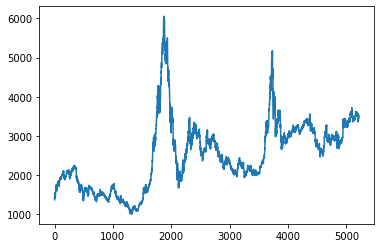

In [34]:
sz['open'].plot()

In [35]:
sz_df.sort_values('classification',ascending=True)
#sz_df.sort_values('month')

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
3721,3,28,22,5,4943.74,4986.50,4614.24,-6.543022,8.067634,782964544,124792600.0,-6.957169,4620.27,0
2503,0,17,20,5,2663.88,2663.88,2557.24,-3.902203,4.170121,82648328,8820761.0,-5.339990,2559.93,0
3250,0,24,26,6,2068.86,2068.86,1958.40,-5.105710,5.640319,109198216,8796984.0,-5.595880,1963.23,0
3902,3,25,8,2,2922.24,2922.24,2729.85,-6.193536,7.047640,270284416,27176714.0,-6.845417,2741.25,0
3778,1,18,34,8,3999.13,4006.34,3743.39,-6.275615,7.024382,543770816,72246720.0,-6.550147,3748.16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4697,1,2,27,7,3042.58,3048.48,3033.78,0.044699,0.484544,214520624,22956662.0,5.321064,3043.94,7
492,2,23,4,1,1355.86,1445.70,1346.17,6.571475,7.393568,10514135,850314.0,5.970407,1444.96,7
498,3,31,5,1,1413.22,1501.33,1413.22,5.551153,6.234698,18800698,1711934.0,6.373394,1491.67,7
2133,0,10,46,11,1782.31,1876.16,1782.31,5.189333,5.265638,91273264,5686729.0,6.778856,1874.80,7


In [36]:
## 3:decrease between 0-1% 4: increase between 0-1%, 
sz_df.classification.value_counts()

4    1760
3    1541
5     876
2     745
1     119
6      99
0      53
7      23
Name: classification, dtype: int64

In [37]:
print(sz_df.classification.values)
slight_increase_probability = (sz_df.classification.values == 4).sum() / len(sz_df)
slight_decrease_probability = (sz_df.classification.values == 3).sum() / len(sz_df)
print(f"slight_increase_probability:{slight_increase_probability},slight_decrease_probability:{slight_decrease_probability}")

[3 4 6 ... 3 3 4]
slight_increase_probability:0.3374233128834356,slight_decrease_probability:0.2954371165644172


# Make change to data

In [38]:
# insert Time into sz_df from another dataframe
Need_date=pd.read_csv('sz2000.csv',parse_dates=['Time'])
Need_date=Need_date.sort_values(by='Time').reset_index(drop=True)

Need_date

,Time,Open,Close,Increase,Rate,Lowest,Highest,Volume,Amount
0,2000-01-04,1368.69,1406.37,39.79,2.91%,1361.21,1407.52,9034034,57.84
1,2000-01-05,1407.83,1409.68,3.31,0.24%,1398.32,1433.78,10579993,86.22
2,2000-01-06,1406.04,1463.94,54.26,3.85%,1400.25,1463.96,13480524,102.10
3,2000-01-07,1477.15,1516.60,52.66,3.60%,1477.15,1522.83,34515708,219.42
4,2000-01-10,1531.71,1545.11,28.51,1.88%,1506.40,1546.72,31253556,208.72
...,...,...,...,...,...,...,...,...,...
5211,2021-08-10,3488.66,3529.93,35.30,1.01%,3477.06,3529.93,345112992,55344032.00
5212,2021-08-11,3527.11,3532.62,2.69,0.08%,3524.04,3544.09,383783552,54194276.00
5213,2021-08-12,3522.72,3524.74,-7.88,-0.22%,3513.45,3538.40,381074592,53816344.00
5214,2021-08-13,3514.47,3516.30,-8.44,-0.24%,3500.80,3540.08,378187296,53290784.00


In [39]:
#insert Time into sz_df from another dataframe
sz_df['time']=Need_date['Time']
sz_df

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification,time
0,1,4,1,1,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,3,2000-01-04
1,2,5,1,1,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,4,2000-01-05
2,3,6,1,1,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,6,2000-01-06
3,4,7,1,1,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,6,2000-01-07
4,0,10,2,1,1531.71,1546.72,1506.40,0.874839,2.676580,31253556,208.72,1.845176,1545.11,5,2000-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,1,10,32,8,3488.66,3529.93,3477.06,1.182976,1.520537,345112992,55344032.00,1.000020,3529.93,5,2021-08-10
5212,2,11,32,8,3527.11,3544.09,3524.04,0.156219,0.568949,383783552,54194276.00,0.076147,3532.62,4,2021-08-11
5213,3,12,32,8,3522.72,3538.40,3513.45,0.057342,0.710128,381074592,53816344.00,-0.223563,3524.74,3,2021-08-12
5214,4,13,32,8,3514.47,3540.08,3500.80,0.052070,1.122029,378187296,53290784.00,-0.240025,3516.30,3,2021-08-13


In [40]:
a=['a','b']
b='c'
[b]+a

['c', 'a', 'b']

In [41]:
##move the time column to the first col 
cols=list(sz_df.columns.values)
print(cols)
print(cols[-1])
print(cols[0:-1])
sz_df=sz_df[ [cols[-1]] + cols[0:-1] ] # notice cols[-1] is a single str, make it to list [cols[-1]]
sz_df.head()


['day_of_week', 'day_of_month', 'week_of_year', 'month', 'open', 'high', 'low', 'rate', 'amplitude', 'volume', 'amount', 'close_change', 'close', 'classification', 'time']
time
['day_of_week', 'day_of_month', 'week_of_year', 'month', 'open', 'high', 'low', 'rate', 'amplitude', 'volume', 'amount', 'close_change', 'close', 'classification']


,time,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,2000-01-04,1,4,1,1,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,3
1,2000-01-05,2,5,1,1,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,4
2,2000-01-06,3,6,1,1,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,6
3,2000-01-07,4,7,1,1,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,6
4,2000-01-10,0,10,2,1,1531.71,1546.72,1506.40,0.874839,2.676580,31253556,208.72,1.845176,1545.11,5


In [42]:
##drop columns 
sz_df.drop(columns=['day_of_week','day_of_month','week_of_year','month'])
#sz_df=sz_df.drop(columns=['day_of_week','day_of_month','week_of_year','month'])

,time,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,2000-01-04,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,3
1,2000-01-05,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,4
2,2000-01-06,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,6
3,2000-01-07,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,6
4,2000-01-10,1531.71,1546.72,1506.40,0.874839,2.676580,31253556,208.72,1.845176,1545.11,5
...,...,...,...,...,...,...,...,...,...,...,...
5211,2021-08-10,3488.66,3529.93,3477.06,1.182976,1.520537,345112992,55344032.00,1.000020,3529.93,5
5212,2021-08-11,3527.11,3544.09,3524.04,0.156219,0.568949,383783552,54194276.00,0.076147,3532.62,4
5213,2021-08-12,3522.72,3538.40,3513.45,0.057342,0.710128,381074592,53816344.00,-0.223563,3524.74,3
5214,2021-08-13,3514.47,3540.08,3500.80,0.052070,1.122029,378187296,53290784.00,-0.240025,3516.30,3


# Save csv file

In [43]:
sz_df.to_csv('modified.csv',index=False)

# Filtering Data

In [44]:
new_df=sz_df.loc[(sz_df['classification']==6) & (sz_df['close']>3000)]
new_df
#new_df.to_csv('new_df.csv')

,time,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
1754,2007-04-20,4,20,16,4,3460.90,3591.46,3460.90,3.562657,3.772429,138889280,15613018.0,3.771553,3584.20,6
1755,2007-04-23,0,23,17,4,3615.79,3710.89,3615.79,2.630131,2.630131,163498112,18316572.0,3.414006,3710.89,6
1804,2007-07-06,4,6,27,7,3599.82,3785.35,3563.54,5.042752,6.224429,80737240,9230633.0,4.376215,3781.35,6
1814,2007-07-20,4,20,29,7,3918.41,4062.12,3918.41,3.584107,3.667559,83110648,10471435.0,3.594861,4058.85,6
1815,2007-07-23,0,23,30,7,4091.24,4220.32,4091.24,2.984914,3.155034,121668968,15433286.0,3.667145,4213.36,6
1824,2007-08-03,4,3,31,8,4440.98,4562.69,4438.96,2.697378,2.787365,115116664,17367268.0,3.355574,4560.77,6
1892,2007-11-14,2,14,46,11,5246.57,5414.61,5165.06,3.166259,4.831502,50992880,8806409.0,4.703207,5412.69,6
1903,2007-11-29,3,29,48,11,4870.86,5011.19,4814.78,2.719643,4.079314,50071548,8119648.5,3.996139,5003.33,6
1940,2008-01-23,2,23,4,1,4572.90,4705.07,4510.50,2.846115,4.313712,87963976,14034815.0,3.046959,4703.05,6
1982,2008-03-28,4,28,13,3,3378.63,3590.75,3357.23,5.964548,6.955734,63291684,9029192.0,4.710976,3580.15,6


In [45]:
## reset index, if drop=true, the old index column dissapears

new_df=new_df.reset_index()
#new_df=new_df.reset_index(drop=True)
#new_df.reset_index(drop=True,inplace=True)  don't need to assign to a new_df=....
new_df

,index,time,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,1754,2007-04-20,4,20,16,4,3460.90,3591.46,3460.90,3.562657,3.772429,138889280,15613018.0,3.771553,3584.20,6
1,1755,2007-04-23,0,23,17,4,3615.79,3710.89,3615.79,2.630131,2.630131,163498112,18316572.0,3.414006,3710.89,6
2,1804,2007-07-06,4,6,27,7,3599.82,3785.35,3563.54,5.042752,6.224429,80737240,9230633.0,4.376215,3781.35,6
3,1814,2007-07-20,4,20,29,7,3918.41,4062.12,3918.41,3.584107,3.667559,83110648,10471435.0,3.594861,4058.85,6
4,1815,2007-07-23,0,23,30,7,4091.24,4220.32,4091.24,2.984914,3.155034,121668968,15433286.0,3.667145,4213.36,6
5,1824,2007-08-03,4,3,31,8,4440.98,4562.69,4438.96,2.697378,2.787365,115116664,17367268.0,3.355574,4560.77,6
6,1892,2007-11-14,2,14,46,11,5246.57,5414.61,5165.06,3.166259,4.831502,50992880,8806409.0,4.703207,5412.69,6
7,1903,2007-11-29,3,29,48,11,4870.86,5011.19,4814.78,2.719643,4.079314,50071548,8119648.5,3.996139,5003.33,6
8,1940,2008-01-23,2,23,4,1,4572.90,4705.07,4510.50,2.846115,4.313712,87963976,14034815.0,3.046959,4703.05,6
9,1982,2008-03-28,4,28,13,3,3378.63,3590.75,3357.23,5.964548,6.955734,63291684,9029192.0,4.710976,3580.15,6


In [46]:
#new_df.describe()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           33 non-null     int64         
 1   time            33 non-null     datetime64[ns]
 2   day_of_week     33 non-null     int64         
 3   day_of_month    33 non-null     int64         
 4   week_of_year    33 non-null     int64         
 5   month           33 non-null     int64         
 6   open            33 non-null     float64       
 7   high            33 non-null     float64       
 8   low             33 non-null     float64       
 9   rate            33 non-null     float64       
 10  amplitude       33 non-null     float64       
 11  volume          33 non-null     int64         
 12  amount          33 non-null     float64       
 13  close_change    33 non-null     float64       
 14  close           33 non-null     float64       
 15  classifi

In [47]:
## use mask to slice date time
start_date='2019-01-01'
end_date='2021-08-01'
mask = (new_df['time']>start_date) & (new_df['time']<end_date)
new_df.loc[mask]

,index,time,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
31,4646,2019-03-29,4,29,13,3,3000.68,3093.03,2999.99,3.001986,3.101344,375083008,38669964.0,3.100208,3090.76,6
32,4952,2020-07-20,0,20,30,7,3243.91,3314.15,3220.68,2.165288,2.902182,418555296,54404568.0,3.017968,3314.15,6


# Aggregate Statistics(Groupby)

In [48]:
sz_df

,time,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
0,2000-01-04,1,4,1,1,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,3
1,2000-01-05,2,5,1,1,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,4
2,2000-01-06,3,6,1,1,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,6
3,2000-01-07,4,7,1,1,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,6
4,2000-01-10,0,10,2,1,1531.71,1546.72,1506.40,0.874839,2.676580,31253556,208.72,1.845176,1545.11,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,2021-08-10,1,10,32,8,3488.66,3529.93,3477.06,1.182976,1.520537,345112992,55344032.00,1.000020,3529.93,5
5212,2021-08-11,2,11,32,8,3527.11,3544.09,3524.04,0.156219,0.568949,383783552,54194276.00,0.076147,3532.62,4
5213,2021-08-12,3,12,32,8,3522.72,3538.40,3513.45,0.057342,0.710128,381074592,53816344.00,-0.223563,3524.74,3
5214,2021-08-13,4,13,32,8,3514.47,3540.08,3500.80,0.052070,1.122029,378187296,53290784.00,-0.240025,3516.30,3


In [49]:
new_df2=sz_df.groupby(['month']).mean()
new_df2

,day_of_week,day_of_month,week_of_year,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
month,,,,,,,,,,,,,
1,2.027160,16.125926,2.866667,2549.631358,2574.401481,2522.039951,0.081414,2.057421,1.180798e+08,1.312829e+07,-0.046257,2549.521210,3.508642
2,1.985795,15.596591,7.250000,2504.080170,2528.933608,2479.723835,0.193043,1.973271,1.278485e+08,1.341403e+07,0.134875,2508.256761,3.667614
3,2.006160,16.002053,11.324435,2505.305318,2527.123634,2482.307454,0.102376,1.756395,1.360564e+08,1.446871e+07,0.029331,2507.652259,3.550308
4,2.040268,15.845638,15.738255,2555.743244,2577.114855,2532.820559,0.106871,1.703328,1.360099e+08,1.530597e+07,0.087736,2558.729776,3.554810
5,2.002392,17.760766,20.289474,2608.399904,2631.717823,2585.197201,0.102437,1.736156,1.237924e+08,1.473104e+07,-0.014421,2611.639545,3.511962
6,2.022573,15.424379,24.386005,2541.473792,2562.553860,2513.097133,-0.019740,1.856730,1.164123e+08,1.437101e+07,-0.135597,2540.539774,3.422122
7,1.997942,16.028807,28.771605,2530.302366,2554.913210,2506.907346,0.128275,1.788556,1.355503e+08,1.570052e+07,0.024566,2534.290144,3.532922
8,2.008386,15.840671,33.167715,2504.212704,2525.914151,2480.925618,0.053587,1.722300,1.161999e+08,1.316669e+07,-0.085497,2505.775094,3.484277
9,1.993023,15.376744,37.555814,2445.493116,2464.500558,2424.740512,0.027176,1.607608,9.947702e+07,1.048736e+07,-0.031043,2446.455279,3.486047


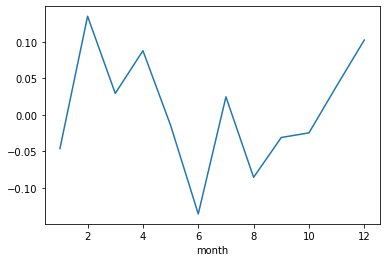

In [50]:
new_df2.close_change.plot()

In [51]:
sz_df.groupby(['month']).mean().sort_values('close_change',ascending=False)

,day_of_week,day_of_month,week_of_year,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
month,,,,,,,,,,,,,
2,1.985795,15.596591,7.250000,2504.080170,2528.933608,2479.723835,0.193043,1.973271,1.278485e+08,1.341403e+07,0.134875,2508.256761,3.667614
12,1.995643,15.912854,48.708061,2506.792309,2528.940893,2487.762702,0.168404,1.620998,1.162617e+08,1.246360e+07,0.102324,2511.691373,3.579521
4,2.040268,15.845638,15.738255,2555.743244,2577.114855,2532.820559,0.106871,1.703328,1.360099e+08,1.530597e+07,0.087736,2558.729776,3.554810
11,2.013333,15.553333,46.282222,2501.584311,2522.699822,2479.466956,0.111312,1.714769,1.159900e+08,1.252754e+07,0.039426,2503.075156,3.553333
3,2.006160,16.002053,11.324435,2505.305318,2527.123634,2482.307454,0.102376,1.756395,1.360564e+08,1.446871e+07,0.029331,2507.652259,3.550308
7,1.997942,16.028807,28.771605,2530.302366,2554.913210,2506.907346,0.128275,1.788556,1.355503e+08,1.570052e+07,0.024566,2534.290144,3.532922
5,2.002392,17.760766,20.289474,2608.399904,2631.717823,2585.197201,0.102437,1.736156,1.237924e+08,1.473104e+07,-0.014421,2611.639545,3.511962
10,1.972376,19.486188,42.430939,2480.733674,2502.076961,2457.497293,0.021076,1.799537,1.015937e+08,1.096725e+07,-0.024678,2482.385470,3.516575
9,1.993023,15.376744,37.555814,2445.493116,2464.500558,2424.740512,0.027176,1.607608,9.947702e+07,1.048736e+07,-0.031043,2446.455279,3.486047


In [52]:
sz_df.groupby(['month']).count()['classification'] == 3

month
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
Name: classification, dtype: bool

# Line graph

In [53]:
sz.describe()

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification
count,5216.000000,5216.00000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5216.000000,5.216000e+03,5.216000e+03,5216.000000,5216.000000,5216.000000
mean,2.006135,16.19421,26.848926,6.570552,2519.723263,2541.948035,2496.340508,0.089576,1.771857,1.207081e+08,1.345850e+07,0.005700,2521.920050,3.528949
std,1.408630,8.58403,14.895513,3.405428,882.418672,892.904364,869.948178,1.400245,1.224128,1.217611e+08,1.570517e+07,1.544520,883.331433,1.138672
min,0.000000,1.00000,1.000000,1.000000,1007.900000,1019.920000,998.230000,-9.086764,0.252384,9.980810e+05,4.403000e+01,-9.698065,1011.500000,0.000000
25%,1.000000,9.00000,14.000000,4.000000,1805.347500,1822.300000,1788.372500,-0.563382,0.970119,2.060173e+07,1.372008e+06,-0.661545,1807.292500,3.000000
50%,2.000000,16.00000,27.000000,7.000000,2468.310000,2494.755000,2446.305000,0.099907,1.420571,9.250523e+07,9.265310e+06,0.058171,2471.110000,4.000000
75%,3.000000,24.00000,39.000000,9.000000,3097.530000,3121.960000,3076.825000,0.738918,2.150044,1.652979e+08,1.828549e+07,0.744162,3103.137500,4.000000
max,4.000000,31.00000,53.000000,12.000000,6057.430000,6124.040000,6040.710000,8.180134,11.229300,8.571328e+08,1.309925e+08,8.972440,6092.060000,7.000000


In [54]:
Index_list=[sz,shenzheng,agu,shenzhengr,dichan,gongye,shangye,gongye]


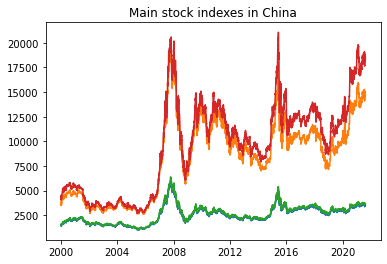

In [55]:

plt.title('Main stock indexes in China')
for i in Index_list[0:4]:    
    plt.plot(sz_df.time,i.close)
plt.show()

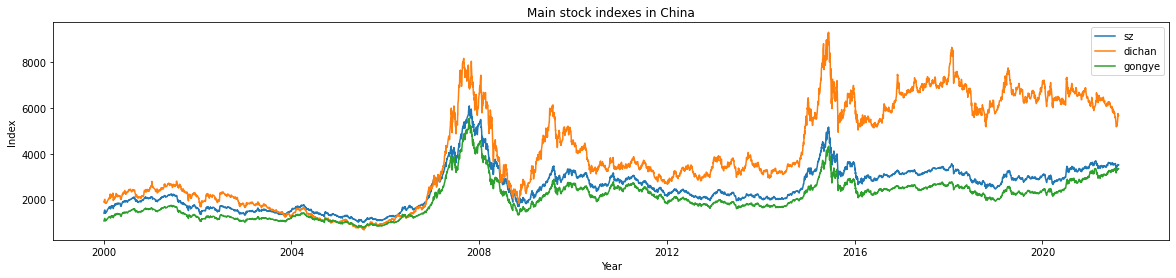

In [56]:
#plt.figure(figsize=(80,20))
plt.figure(figsize=(20,4))
plt.title('Main stock indexes in China')

plt.plot(sz_df.time,sz.close,label='sz')
plt.plot(sz_df.time,dichan.close,label='dichan')
plt.plot(sz_df.time,gongye.close,label='gongye')

plt.xlabel('Year')
plt.ylabel('Index')

plt.legend()
plt.show()

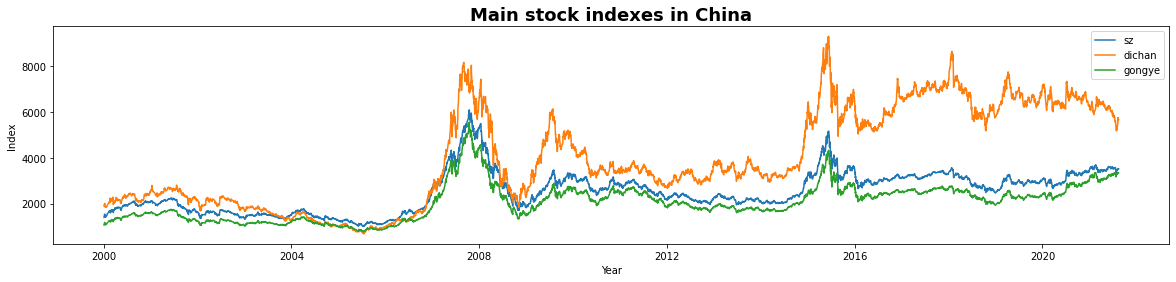

In [57]:
#plt.figure(figsize=(80,20))
plt.figure(figsize=(20,4))
plt.title('Main stock indexes in China',fontdict={'fontweight':'bold',
                                                 'fontsize':18})

plt.plot(sz_df.time,sz.close,label='sz')
plt.plot(sz_df.time,dichan.close,label='dichan')
plt.plot(sz_df.time,gongye.close,label='gongye')

plt.xlabel('Year')
plt.ylabel('Index')

plt.legend()

plt.savefig('sz&dichan&gongye.png',dpi=300)

plt.show()

# Histograms

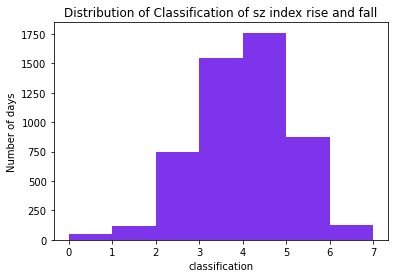

In [58]:
bins=[0,1,2,3,4,5,6,7]

plt.hist(sz_df.classification,bins=bins,color='#7d34eb') # use google color picker 

plt.xticks(bins)

plt.ylabel('Number of days')
plt.xlabel('classification')
plt.title('Distribution of Classification of sz index rise and fall')

plt.yticks

plt.show()

# Pie charts

In [59]:
sz

,day_of_week,day_of_month,week_of_year,month,open,high,low,rate,amplitude,volume,amount,close_change,close,classification,time
0,1,4,1,1,1368.69,1407.52,1361.21,2.752997,3.402120,9034034,57.84,0.000000,1406.37,3,2000-01-04
1,2,5,1,1,1407.83,1433.78,1398.32,0.131408,2.535900,10579993,86.22,0.234805,1409.68,4,2000-01-05
2,3,6,1,1,1406.04,1463.96,1400.25,4.117948,4.549902,13480524,102.10,3.706436,1463.94,6,2000-01-06
3,4,7,1,1,1477.15,1522.83,1477.15,2.670683,3.092442,34515708,219.42,3.472241,1516.60,6,2000-01-07
4,0,10,2,1,1531.71,1546.72,1506.40,0.874839,2.676580,31253556,208.72,1.845176,1545.11,5,2000-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,1,10,32,8,3488.66,3529.93,3477.06,1.182976,1.520537,345112992,55344032.00,1.000020,3529.93,5,2021-08-10
5212,2,11,32,8,3527.11,3544.09,3524.04,0.156219,0.568949,383783552,54194276.00,0.076147,3532.62,4,2021-08-11
5213,3,12,32,8,3522.72,3538.40,3513.45,0.057342,0.710128,381074592,53816344.00,-0.223563,3524.74,3,2021-08-12
5214,4,13,32,8,3514.47,3540.08,3500.80,0.052070,1.122029,378187296,53290784.00,-0.240025,3516.30,3,2021-08-13


In [60]:
sz_increase_days = sz.loc[sz.rate>0.5].count()[0]
sz_decrease_days = sz.loc[sz.rate<-0.5].count()[0]
sz_remain = sz.loc[(sz.rate>=-0.5)&(sz.rate<=0.5)].count()[0]
sz_increase_days

1697

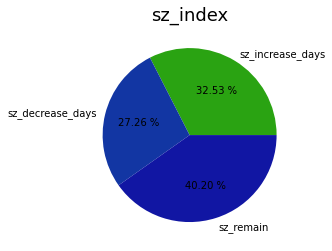

In [61]:

labels=['sz_increase_days','sz_decrease_days','sz_remain']
colors = ['#2aa312','#1236a3','#1116a3']
plt.pie([sz_increase_days,sz_decrease_days,sz_remain],labels=labels,colors=colors,autopct='%.2f %%')
plt.title('sz_index',fontdict={  'fontsize':18})
plt.show()

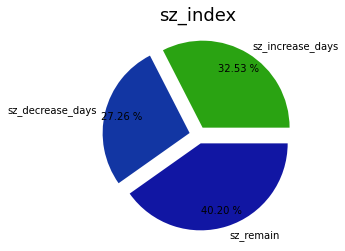

In [62]:
plt.style.use('ggplot')
labels=['sz_increase_days','sz_decrease_days','sz_remain']
explode = (.1,.1,.1)
plt.pie([sz_increase_days,sz_decrease_days,sz_remain],labels=labels,
        colors=colors,
        autopct='%.2f %%',
        pctdistance=0.8,
        explode=explode)
plt.title('sz_index',fontdict={  'fontsize':18})
plt.show()

In [63]:
new_df=pd.read_csv('sz2000.csv',parse_dates=['Time'])
new_df

,Time,Open,Close,Increase,Rate,Lowest,Highest,Volume,Amount
0,2021-08-16,3514.34,3517.34,1.05,0.03%,3510.90,3537.85,391099712,53545892.00
1,2021-08-13,3514.47,3516.30,-8.44,-0.24%,3500.80,3540.08,378187296,53290784.00
2,2021-08-12,3522.72,3524.74,-7.88,-0.22%,3513.45,3538.40,381074592,53816344.00
3,2021-08-11,3527.11,3532.62,2.69,0.08%,3524.04,3544.09,383783552,54194276.00
4,2021-08-10,3488.66,3529.93,35.30,1.01%,3477.06,3529.93,345112992,55344032.00
...,...,...,...,...,...,...,...,...,...
5211,2000-01-10,1531.71,1545.11,28.51,1.88%,1506.40,1546.72,31253556,208.72
5212,2000-01-07,1477.15,1516.60,52.66,3.60%,1477.15,1522.83,34515708,219.42
5213,2000-01-06,1406.04,1463.94,54.26,3.85%,1400.25,1463.96,13480524,102.10
5214,2000-01-05,1407.83,1409.68,3.31,0.24%,1398.32,1433.78,10579993,86.22


In [64]:
new_df.Rate=[float(x.strip('%')) if type(x)==str else x for x in new_df.Rate]
new_df

,Time,Open,Close,Increase,Rate,Lowest,Highest,Volume,Amount
0,2021-08-16,3514.34,3517.34,1.05,0.03,3510.90,3537.85,391099712,53545892.00
1,2021-08-13,3514.47,3516.30,-8.44,-0.24,3500.80,3540.08,378187296,53290784.00
2,2021-08-12,3522.72,3524.74,-7.88,-0.22,3513.45,3538.40,381074592,53816344.00
3,2021-08-11,3527.11,3532.62,2.69,0.08,3524.04,3544.09,383783552,54194276.00
4,2021-08-10,3488.66,3529.93,35.30,1.01,3477.06,3529.93,345112992,55344032.00
...,...,...,...,...,...,...,...,...,...
5211,2000-01-10,1531.71,1545.11,28.51,1.88,1506.40,1546.72,31253556,208.72
5212,2000-01-07,1477.15,1516.60,52.66,3.60,1477.15,1522.83,34515708,219.42
5213,2000-01-06,1406.04,1463.94,54.26,3.85,1400.25,1463.96,13480524,102.10
5214,2000-01-05,1407.83,1409.68,3.31,0.24,1398.32,1433.78,10579993,86.22


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


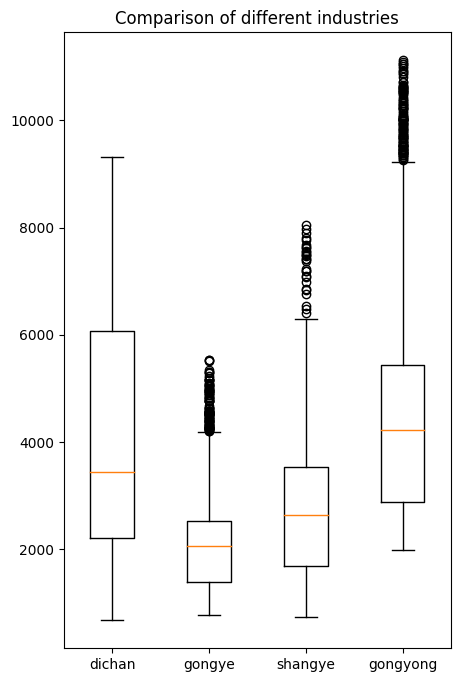

In [65]:
plt.style.use('default')
plt.figure(figsize=(5,8))
dichan_index = dichan.close
gongye_index=gongye.close
shangye_index=shangye.close
gongyong_index=gongyong.close
labels = ['dichan','gongye','shangye','gongyong']
plt.boxplot([dichan_index,gongye_index,shangye_index,gongyong_index],labels=labels)
plt.title("Comparison of different industries")
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


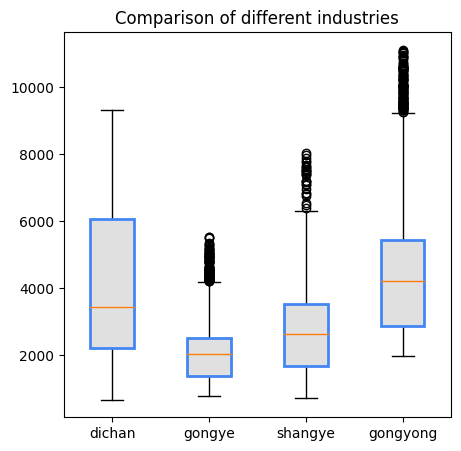

In [66]:
plt.style.use('default')
plt.figure(figsize=(5,5))
dichan_index = dichan.close
gongye_index=gongye.close
shangye_index=shangye.close
gongyong_index=gongyong.close
labels = ['dichan','gongye','shangye','gongyong']
boxes=plt.boxplot([dichan_index,gongye_index,shangye_index,gongyong_index],labels=labels, patch_artist=True)

for box in boxes['boxes']:
    # set edge color
    box.set(color='#4286f4',linewidth=2)
    # set fill color
    box.set(facecolor='#e0e0e0')
    
plt.title("Comparison of different industries")
plt.show()

# A T-GNN model
## The model only consider the close feature for different index.

## Datasets and dataloader

In [67]:
Index_list=[sz,shenzheng,agu,shenzhengr,dichan,gongye,shangye,gongyong]
Index_name=['sz','shenzheng','agu','shenzhengr','dichan','gongye','shangye','gongyong']
new_df=pd.DataFrame()
for i, item in enumerate(Index_list):
  new_df[f'{Index_name[i]}']=item.close

new_df

,sz,shenzheng,agu,shenzhengr,dichan,gongye,shangye,gongyong
0,1406.37,3497.06,1494.50,4048.28,1891.53,1066.91,1221.21,2021.82
1,1409.68,3486.29,1498.05,4040.06,1891.96,1070.86,1240.39,2013.40
2,1463.94,3655.20,1555.95,4238.79,1940.04,1114.82,1272.67,2085.36
3,1516.60,3828.04,1611.81,4437.23,1986.82,1156.30,1333.76,2164.58
4,1545.11,3921.48,1642.53,4547.71,2013.28,1179.13,1374.91,2182.58
...,...,...,...,...,...,...,...,...
5211,3529.93,15057.59,3699.68,18845.40,5560.14,3368.10,2895.91,4030.94
5212,3532.62,15021.17,3702.51,18799.82,5756.95,3361.50,2909.44,4029.31
5213,3524.74,14901.97,3694.23,18650.93,5721.15,3359.52,2896.36,4061.19
5214,3516.30,14799.03,3685.34,18522.78,5659.05,3348.46,2890.64,NaN


In [68]:
adj=np.zeros((8,8))
for i in range(8):
  for j in range(8):
    adj[i][j]=new_df.iloc[:,i].corr(new_df.iloc[:,j])
adj

array([[1.        , 0.9347796 , 0.99997252, 0.92610346, 0.87595481,
        0.99149147, 0.86472672, 0.9430321 ],
       [0.9347796 , 1.        , 0.93434222, 0.99053008, 0.82069632,
        0.951845  , 0.87343942, 0.8581289 ],
       [0.99997252, 0.93434222, 1.        , 0.92549649, 0.87478083,
        0.99141297, 0.863616  , 0.94275583],
       [0.92610346, 0.99053008, 0.92549649, 1.        , 0.86450061,
        0.9396554 , 0.86966808, 0.82685852],
       [0.87595481, 0.82069632, 0.87478083, 0.86450061, 1.        ,
        0.84168337, 0.79846745, 0.80637194],
       [0.99149147, 0.951845  , 0.99141297, 0.9396554 , 0.84168337,
        1.        , 0.84931   , 0.91861733],
       [0.86472672, 0.87343942, 0.863616  , 0.86966808, 0.79846745,
        0.84931   , 1.        , 0.87963672],
       [0.9430321 , 0.8581289 , 0.94275583, 0.82685852, 0.80637194,
        0.91861733, 0.87963672, 1.        ]])

In [69]:
data = 10*np.random.rand(5,5)
max_value=[]
print(data)
for i in range(data.shape[1]):
  max_value.append(data[:,i].max())
for i in range(data.shape[1]):
  data[:,i]=data[:,i]/max_value[i]
print(data)

[[0.8669564  2.26915087 1.49358775 7.24826002 4.22004669]
 [8.19684426 4.66838641 9.22655909 6.4502717  5.28119836]
 [3.17557403 0.39209399 9.70494203 7.51586971 2.77567239]
 [2.65974996 8.64136123 5.40834479 8.93091695 0.46897796]
 [7.05737614 4.34286317 2.39098119 9.990397   3.18482015]]
[[0.10576709 0.26259183 0.15389971 0.72552272 0.79906991]
 [1.         0.54023739 0.95070729 0.64564718 1.        ]
 [0.38741422 0.0453741  1.         0.75230941 0.52557624]
 [0.32448463 1.         0.55727739 0.89395016 0.08880143]
 [0.86098697 0.50256702 0.24636739 1.         0.60304876]]


In [70]:

def load_features(features,dtype=np.float32):
  return np.array(features,dtype=dtype)
def load_adjacency_matrix(adj,dtype=np.float32):
  return np.array(adj,dtype=dtype)
def generate_dataset(
    data,seq_len,pre_len,time_len=None,split_ratio=0.9,normalize=True
):
  '''
  :param data: feature matrix
  :param seq_len: length of the train data sequence
  :param pre_len: length of the prediction data sequence
  :param time_len: length of the time series in total
  :param split_ratio: proportion of the training set
  :param normalize: scale the data to (0,1], divide by the maximum value in the data
  :return: train set (X,Y) and test set (X,Y)
  '''
  if time_len is None:
    time_len = data.shape[0]
  if normalize:
    max_values=[]
    for i in range(data.shape[1]):
      max_values.append(data[:,i].max())
    for i in range(data.shape[1]):
      data[:,i]=data[:,i]/max_values[i]

  train_size=int(time_len * split_ratio)
  train_data=data[:train_size]
  test_data=data[train_size:time_len]
  train_X,train_Y,test_X,test_Y=list(),list(),list(),list()
  for i in range(len(train_data)-seq_len-pre_len):
    train_X.append(np.array(train_data[i:i+seq_len]))
    train_Y.append(np.array(train_data[i+seq_len:i+seq_len+pre_len]))
  for i in range(len(test_data)-seq_len-pre_len):
    test_X.append(np.array(test_data[i:i+seq_len]))
    test_Y.append(np.array(test_data[i+seq_len:i+seq_len+pre_len]))
  return np.array(train_X),np.array(train_Y),np.array(test_X),np.array(test_Y)

def generate_torch_datasets(
    data,seq_len,pre_len,time_len=None,split_ratio=0.9,normalize=True):
  train_X,train_Y,test_X,test_Y=generate_dataset(
      data,
      seq_len,
      pre_len,
      time_len=time_len,
      split_ratio=split_ratio,
      normalize=normalize
  )
  train_dataset = torch.utils.data.TensorDataset(
      torch.FloatTensor(train_X), torch.FloatTensor(train_Y)
  )
  test_dataset = torch.utils.data.TensorDataset(
      torch.FloatTensor(test_X),torch.FloatTensor(test_Y)
  )
  return train_dataset,test_dataset





In [71]:
data=load_features(new_df)
adj=load_adjacency_matrix(adj)
train_dataset,test_dataset=generate_torch_datasets(data,120,1)

In [72]:
class TGNN_DataModule(pl.LightningDataModule):
  def __init__(
      self,
      batch_size: int = 64,
      seq_len: int = 120,
      pre_len: int = 1,
      split_ratio: float = 0.9,
      normalize : bool = True,
      adj,
      data,
      **kwargs
  ):
    super(TGNN_DataModule,self).__init__()
    self.batch_size=batch_size
    self.seq_len=seq_len
    self.pre_len=pre_len
    self.split_ratio=split_ratio
    self.normalize=normalize
    self._feat=data
    self._adj=adj
  @staticmethod
  def add_data_specific_arguments(parent_parser):
    parser = argparse.ArgumentParser(parents=[parent_parser],add_help=False)
    parser.add_argument('--batch_size',type=int,default=32)
    parser.add_argument('--seq_len',type=int,default=120)
    parser.add_argument('--pre_len',type=int, default=1)
    parser.add_argument('--split_ratio',type=float,default=0.9)
    parser.add_argument('--normalize',type=bool,default=True)
    return parser 
  
  def setup(self,stage:str=None):
    (self.train_dataset,
     self.val_dataset)=generate_torch_datasets(self._feat,
                          self.seq_len,
                          self.pre_len,
                          split_ratio=self.split_ratio,
                          normalize=self.normalize
                          )
  def trian_dataloader(self):
    return DataLoader(self.train_dataset,batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size=len(self.val_dataset)) # batch size=total sample nums,



## Create T_GNN model

In [74]:
def calculate_laplacian_with_self_loop(matrix):
  matrix=matrix+torch.eye(matrix.size(0))
  row_sum=matrix.sum(1)
  d_inv_sqrt=torch.pow(row_sum,-0.5).flatten()
  d_inv_sqrt[torch.isinf(d_inv_sqrt)]=0.0
  d_mat_inv_sqrt=torch.diag(d_inv_sqrt)
  normalized_laplacian = (
      matrix.matmul(d_mat_inv_sqrt).transpose(0,1).matmul(d_mat_inv_sqrt)
  )
  return normalized_laplacian

In [80]:
class TGCNGraphConvolution(nn.Module):
  def __init__(self,adj,num_gru_units:int,output_dim:int,bias:float =0.0):
    super(TGCNGraphConvolution,self).__init__()
    self._num_gru_units=num_gru_units
    self._output_dim=output_dim
    self._bias_init_value=bias
    self.register_buffer(
        'laplacian',calculate_laplacian_with_self_loop(torch.FloatTensor(adj))
    )
    self.weights=nn.Parameter(
        torch.FloatTensor(self._num_gru_units+1,self._output_dim)
    )
    self.biases=nn.Parameter(torch.FloatTensor(self._output_dim))
    self.reset_parameters()
  
  def reset_parameters(self):
    nn.init.xavier_uniform_(self,weights)
    nn.init.constant_(self.biases,self._bias_init_value)

  def forward(self,inputs,hidden_state):
    batch_size,num_nodes=inputs.shape 
    # inputs (batch_size, num_nodes) -> (batch_size, num_nodes, 1)
    inputs=inputs.reshape((batch_size,num_nodes,1))
    # hidden_state (batch_size, num_nodes, num_gru_units)
    hidden_state=hidden_state.reshape(
        (batch_size,num_nodes,self._num_gru_units)
    )
    # [x, h] (batch_size, num_nodes, num_gru_units + 1)
    concatenation=torch.cat((inputs,hidden_state),dim=2)
    # [x, h] (num_nodes, num_gru_units + 1, batch_size)
    concatenation = concatenation.transpose(0,1).transpose(1,2)
    # [x, h] (num_nodes, (num_gru_units + 1) * batch_size)
    concatenation = concatenation.reshape(
        (num_nodes,(self._num_gru_units+1)*batch_size)

    )
    # A[x, h] (num_nodes, (num_gru_units + 1) * batch_size)
    a_times_concat = self.laplacian @ concatenation
    # A[x, h] (num_nodes, num_gru_units + 1, batch_size)
    a_times_concat = a_times_concat.reshape(
        (num_nodes,self._num_gru_units+1,batch_size)
    )
    # A[x, h] (batch_size, num_nodes, num_gru_units + 1)
    a_times_concat = a_times_concat.transpose(0,2).transpose(1,2)
    # A[x, h] (batch_size * num_nodes, num_gru_units + 1)
    a_times_concat = a_times_concat.reshape(
        (batch_size*num_nodes, self._num_gru_units+1)
    )
    # A[x, h]W + b (batch_size * num_nodes, output_dim)
    outputs=a_times_concat @ self.weights +self.biases\
    # A[x, h]W + b (batch_size, num_nodes, output_dim)
    outputs=outputs.reshape((batch_size,num_nodes,self._output_dim))
    # A[x, h]W + b (batch_size, num_nodes * output_dim)
    outputs=outputs.reshape((batch_size,num_nodes*self._output_dim))
    return outputs
  @property
  def hyperparameters(self):
    return {
        'num_gru_units':self._num_gru_units,
        'output_dim':self._output_dim,
        'bias_init_value':self._bias_init_value,
    }

class TGCNCell(nn.Module):
  def __init__(self,adj,input_dim:int,hidden_dim:int):
    super(TGCNCell,self).__init__()
    self._input_dim = input_dim
    self._hidden_dim = hidden_dim
    self.register_buffer('adj',torch.FloatTensor(adj))
    self.graph_conv1=TGCNGraphConvolution(
        self.adj,self._hidden_dim,self._hidden_dim *2, bias=1.0
    )
    self.graph_conv2=TGCNGraphConvolution(
        self.adj,self._hidden_dim,self._hidden_dim
    )
  
  def forward(self, inputs, hidden_state):
    # [r, u] = sigmoid(A[x, h]W + b)
    # [r, u] (batch_size, num_nodes * (2 * num_gru_units)) 
    concatenation = torch.sigmoid(self.graph_conv1(inputs,hidden_state))
    # r (batch_size, num_nodes, num_gru_units)
    # u (batch_size, num_nodes, num_gru_units) 
    r,u=torch.chunk(concatenation,chunks=2,dim=1)
    # c = tanh(A[x, (r * h)W + b])
    # c (batch_size, num_nodes * num_gru_units) 
    c=torch.tanh(self.graph_conv2(inputs,r*hidden_state))
    # h := u * h + (1 - u) * c
    # h (batch_size, num_nodes * num_gru_units)
    new_hidden_state=u*hidden_state+(1.0-u)*c
    return new_hidden_state,new_hidden_state

  @property
  def hyperparameters(self):
    return {'input_dim':self._input_dim,'hidden_dim':self._hidden_dim}

class TGCN(nn.Module):
  def __init__(self,adj,hidden_dim:int,**kwargs):
    super(TGCN,self).__init__()
    self._input_dim=adj.shape[0]
    self._hidden_dim=hidden_dim
    self.register_buffer('adj',torch.FloatTensor(adj))
    self.tgcn_cell = TGCNCell(self.adj,self._input_dim,self._hidden_dim)

  def forward(self,inputs):
    batch_size,seq_len,num_nodes=inputs.shape
    assert self._input_dim==num_nodes
    hidden_state=torch.zeros(batch_size,num_nodes*self._hidden_dim).type_as(inputs)
    output=None
    for i in range(seq_len):
      output,hidden_state=self.tgcn_cell(inputs[:,i,:],hidden_state)
      output = output.reshape((batch_size,num_nodes,self._hidden_dim))
      return output
  @staticmethod
  def add_model_specific_arguments(parent_parser):
    parser = argparse.ArgumentParser(parents=[parent_parser],add_help=False)
    parser.add_argument('--hidden_dim',type=int,default=64)
    return parser

  @property
  def hyperparameters(self):
    return{"input_dim":self._input_dim,'hidden_dim':self._hidden_dim}


## SupervisedForecastTask()

In [81]:
import argparse
import torch.optim
import torch.nn.functional as F
import torchmetrics


### accuracy

In [ ]:
def accuracy(pred,y):
  '''
  :param pred: predictions
  :param y: ground truth
  :return : accuracy, defined as 1-(norm(y-pred)/norm(y))

  '''
  return 1 - torch.linalg.norm(y-pred,'fro') / torch.linalg.norm(y,'fro')

def r2(pred,y):
  '''
  :return : R square (coefficient of determination)
  '''
  return 1-torch.sum((y-pred)**2)/torch.sum((y-torch.mean(pred))**2)

def explained_variance(pred, y):
  return 1-torch.var(y-pred)/torch.var(y)


### loss

In [ ]:
def mse_with_regularizer_loss(inputs,targets,model,lamda=1.5e-3):
  reg_loss=0.0
  for param in model.parameters():
    reg_loss += torch.sum(param**2)/2
  reg_loss = lamda*mse_with_regularizer_loss
  mse_loss = torch.sum((inputs-targets)**2)/2
  return mse_loss + reg_loss

In [ ]:
class SupervisedForecastTask(pl.LightningModule):
  def __init__(
      self,
      model:nn.Module,
      regressor='linear',
      loss='mse',
      pre_len:int=1,
      learning_rate:float = 1e-3,
      weight_decay : float = 1.5e-3,
      feat_max_val:float=1.0,
      **kwargs
  )
    super(SupervisedForecastTask,self).__init__()
    self.save_hyperparameters()
    self.model=model
    self.regressor=(
        nn.Linear(
            self.model.hyperparameters.get('hidden_dim')
            or self.model.hyperparameters.get('output_dim'),
            self.hparams.pre_len,
        )
        if regressor=='linear'
        else regressor
    )
    self._loss=loss 
    self.feat_max_val = feat_max_val #6124

  def accuracy(self,pred,y):
    '''
    :param pred: predictions
    :param y: ground truth
    :return : accuracy, defined as 1-(norm(y-pred)/norm(y))

    '''
    return 1 - torch.linalg.norm(y-pred,'fro') / torch.linalg.norm(y,'fro')

  def r2(self,pred,y):
    '''
    :return : R square (coefficient of determination)
    '''
    return 1-torch.sum((y-pred)**2)/torch.sum((y-torch.mean(pred))**2)

  def explained_variance(self,pred, y):
    return 1-torch.var(y-pred)/torch.var(y)

  def mse_with_regularizer_loss(self,inputs,targets,model,lamda=1.5e-3):
    reg_loss=0.0
    for param in model.parameters():
      reg_loss += torch.sum(param**2)/2
    reg_loss = lamda*mse_with_regularizer_loss
    mse_loss = torch.sum((inputs-targets)**2)/2
    return mse_loss + reg_loss

  def forward(self,x):
    #(batch_size,seq_len,num_nodes)
    batch_size,_,num_nodes=x.size()
    #(batch_size,num_nodes,hidden_dim)
    hidden = self.model(x)
    #batch_size*num_nodes,hidden_dim
    hidden=hidden.reshape((-1,hiddens.size(2)))
    #(batch_size*num_nodes,pre_len)
    if self.regressor is not None:
      predictions=self.regressor(hidden)
    else:
      predictions=hidden
    predictions=predictions.reshape((batch_size,num_nodes,-1))
    return predictions
  def shared_step(self,batch,batch_idx):
    # (batchs_size,seq_len/pre_len,num_nodes)
    x,y=batch
    num_nodes=x.size(2)
    predictions=self(x)
    predictions=predictions.transpose(1,2).reshape((-1,num_nodes))
    y=y.reshape((-1,y.size(2)))
    return predictions,y

  def loss(self,inputs,targets):
    if self._loss=='mse':
      return F.mse_loss(inputs,targets)
    if self._loss=='mse_with_regularizer':
      return self.mse_with_regularizer_loss(inputs,targets,self)
    raise NameError('Loss not supported',self._loss)

  def training_step(self,batch,batch_idx):
    predictions,y = self.shared_step(batch,batch_idx)
    loss = self.loss(predictions,y)
    self.log('train_loss',loss)
    return loss
  
  def validation_step(self,batch,batch_idx):
    predictions,y=self.shared_step(batch,batch_idx)
    predictions=prediction * self.feat_max_val
    y = y* self.feat_max_val # only for validation_step, Notice. 
    loss = self.loss(prediction,y)
    rmse = torch.sqrt(trochmetrics.functional.mean_squared_error(predictions,y))
    mae = torchmetrics.fuctional.mean_absulute_error(predictions,y)
    accuracy = self.accuracy(predictions,y)  # self.accuracy ,write into the class?
    r2 = self.r2(predictions,y)
    explained_variance = self.explained_variance(predictions,y)
    metrics={
        'val_loss':loss,
        'RMSE':rmse,
        'MAE':mae,
        'accuracy':accuracy,
        'R2':r2,
        'ExplainedVar':explained_variance,
    }
    self.log_dict(metrics)
    return predictions.reshape(batch[1].size()),y.reshape(batch[1].size())

  def test_step(self, batch,batch_idx):
    pass

  def configure_optimizer(self):
    return torch.optim.Adam(

      self.parameters(),
      lr=self.hparams.learning_rate,
      weight_decay=self.hparams.weight_decay,
    )
  @staticmethod
  def add_task_specific_arguments(parent_parser):
    parser = argparse.ArgumentParser(parents=[parent_parser],add_help=False)
    parser.add_argument('--learning_rate','--lr',type=float,default=1e-3)
    parser.add_argument('--weight_decay','--wd',type=float,default=1.5e-3)
    parser.add_argument('--lose',type=str,default='mse')
    return parser
  

In [ ]:
#best epoch
from pytorch_lightning.utilities import rank_zero_warn
from pytorch_lightning.callbacks import Callback
import copy 
import numpy as np

class BestEpochCallback(Callback):
  TORCH_INF = torch_inf=torch.tensor(np.Inf)
  MODE_DICT = {
      'min':(torch_inf,'min')
      'max':(-torch_inf,'max')
  }
  MONITOR_OP_DICT={'min':torch.lt,'max':torch.gt}

  def __init__(self,monitor='',mode='min'):
    super(BestEpochCallback,self).__init__()
    self.monitor=monitor
    self.__init_monitor_mode(monitor,,mode)
    self.best_epoch=0

  def __init_monitor_mode(self,monitor,mode):
    if mode not in self.MODE_DICT and mode != 'auto':
      rank_zero_warn{
          f'PrintBestEpochMetrics mode {mode} is unknown,fallback to auto mode',
          RuntimeWarning,
      }
      mode = 'auto'

    if mode == 'auto':
      rank_zero_warn(
          'mode='auto' is deprecated in v1.1 and will be removed in v1.3'
          'Default walue for mode with be 'min' in v1.3.',
          DeprecationWarning,
      )
      self.MODE_DICT['auto']=(
          (-self.TORCH_INF,'max')
          if monitor is not None
          and ('acc' in monitor or monitor.startswith('fmeasure'))
          else (self.TORCH_INF,'min')
      )
    self.best_value,self.mode = self.MODE_DICT[mode]

  def on_validation_batch_end(
      self,trainer,pl_module,outputs,batch,batch_idx,dataloader_idx
  ):
    if (trainer.current_epoch+1) % trainer.check_val_every_n_epoch !=0:
      return
    monitor_op = self.MONITOR_OP_DICT[self.mode]
    metrics_dict=copy.copy(trainer.callback_metrics)
    monitor_value = metrics_dict.get(self.monitor,self.best_value)
    if monitor_op(monitor_value,self.best_value):
      self.best_value=monitor_value
      self.best_epoch = trainer.current_epoch


In [ ]:
# plot_validation_predictions
import matplotlib.pyplot as plt
class PlotVlidationPredictionsCallback(BestEpochCallback):
  def __init__(self,monitor='',mode='min'):
    super(PlotValidationPredictionsCallback,self).__init__(monitor=monitor,mode=mode)
    self.ground_truths=[]
    self.predictions=[]
  def on_fit_start(self,trainer,pl_module):
    self.ground_truths.clear()
    self.predictions.clear()

  def on_validation_batch_end(self,trainer,pl_module,outputs,batch,batch_idx,dataloader_idx): # whats outputs
    super().on_validation_batch_end(trainer,pl_module,outputs,batch,batch_idx,dataloader_idx)
    if trainer.current_epoch
    self.ground_truths.clear()
    self.predictions.clear()
    predictions,y=outputs
    self.ground_truths.append(y[:,0,:])
    self.predictions.append(predictions[:,0,:])

  def on_fit_end(self, trainer, pl_module):
    ground_truth = torch.cat(self.ground_truths,dim=0).cpu().numpy()
    predictions=torch.cat(self.predictions,dim=0).cpu().numpy()
    tensorboard = pl_module.logger.experiment
    for node_idx in range(ground_truth.shape[1]):
      plt.clf()
      plt.rcParams['font.family']='Times New Roman'
      fig = plt.figure(figsize=(7,2),dpi=300)
      plt.plot(
          ground_truth[:,node_idx],
          color='dimgray',
          linestyle='-',
          label = "ground truth",

      )
      plt.plot(
          predictions[:,node_idx],
          color='deepskyblue',
          linestyle='-',
          label = 'Predictions',
      )
      plt.legend(loc='best',fontsize=10)
      plt.xlabel("Time")
      plt.ylabel("Index")

      tensorboard.add_figure(
          'Prediction result of node' + str(node_idx),
          fig,
          global_step = len(trainer.train_dataloader) * self.best_epoch,
          close=True,

      )

In [ ]:
def get_callbacks(args):
  checkpoint_callback=pl.callbacks.ModelCheckpoint(monitor='train_loss')
  plot_validation_predictions_callback = PlotValidationPredictionsCallback(monitor="train_loss")
  callbacks = [
      checkpoint_callback,
      plot_validation_predictions_callback,
  ]
  return callbacks
def main_supervised(args):
  dm=SpatioTemporalCSVDataModule(
    adj=adj,
    data=data,
    **vars(args)
  )
  model = TGCN(adj,hidden_dim=args.hidden_dim)
  task = SupervisedForecastTask(model=model,feat_max_val=6124,**vars(args))
  callbacks=get_callbacks(args)
  trainer=pl.Trainer.from_argparse_args(args,callbacks=callbacks)
  trainer.fit(task,dm)
  results=trainer.validate()
  return results
def main(args):
  rank_zero_info(vars(args))
  results=globals()['main_'+args.settings](args)
  return results

if __name__=='__main__':
  parser = argparse.ArgumentParser()
  parser=pl.Trainer.add_argparse_args(parser)

  parser.add_argument(
      '--data',type=str,help='The name of the dataset',choices=('New_df'),default='New_df'
  )
  parser.add_argument(
      '--model_name',
      type=str,
      help = 'The name of the model for spatiotemporal prediction',
      choices=("TGCN"),
      default='TGCN',
  )
  parser.add_argument(
      '--settings',
      type=str,
      help='The type of settings, e.g. supervised learning',
      choice = ('supervised',),
      default='supervised',
  )
  parser.add_argument('--log_path',type=str,default=None,help='path to the output console log file')

  temp_args,_=parser.parse_known_args()

  parser = getattr(TGNN_DataModule).add_data_specific_arguments(parser)dd_data_
  parser = getattr(TGCN).add_model_specific_arguments(parser)
  parser = getattr(SupervisedForecastTask).add_model_specific_arguments(parser)

  args = parser.parse_args()
  

In [ ]:
def main(args):
  rank_zero_info(vars(args))
  results = globals()['main_'+args.settings](args)
  return results

